In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat
from numpy import ndarray
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# fungsi untuk merubah data menjadi supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')

mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
mobility.set_index('date', inplace=True)

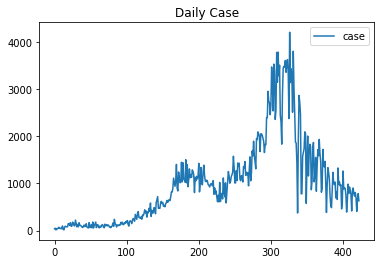

In [4]:
case.plot()
plt.title("Daily Case")
plt.show()

In [5]:
# interpolasi untuk missing data value
new_weather = weather.interpolate(method='spline', order=2)

new_date = weather[['date']]

new_weather.set_index('date', inplace=True)

In [6]:
case['date'] = case['date'].astype('datetime64[ns]')
case.set_index('date', inplace=True)
case.head()

,case
date,
2020-03-18,38
2020-03-19,50
2020-03-20,14
2020-03-21,44
2020-03-22,36


In [7]:
# seasonal decomposition untuk memisahkan data
decompose = seasonal_decompose(case, model='additive', extrapolate_trend='freq')

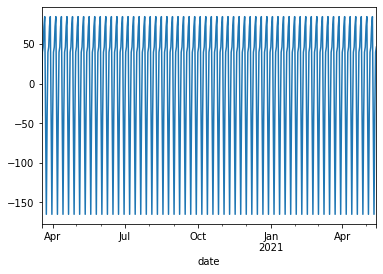

In [8]:
decompose.seasonal.plot()
plt.show()

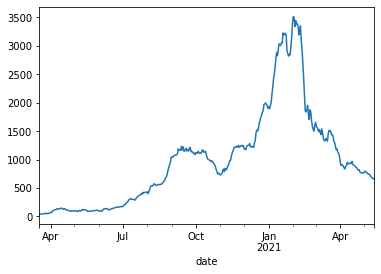

In [9]:
decompose.trend.plot()
plt.show()

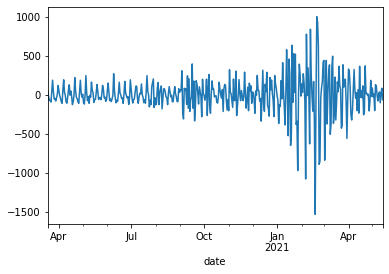

In [10]:
decompose.resid.plot()
plt.show()

In [11]:
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
actual = decompose.observed

In [12]:
new_trend = trend.to_frame()
new_seasonal = seasonal.to_frame()
new_residual = residual.to_frame()
new_actual = actual.to_frame()

In [13]:
# Ambil data untuk evaluasi
data_evaluasi = case[413:]

#total split data untuk LSTM
n_total = 412

# Split data ARIMA
train_ARIMA = new_trend[:412]
test_ARIMA = new_trend[412:]

#jumlah neuron
neu = int(2/3*(n_total+1))
neuron_seasonal = neu
neuron_residual = neu

# Parameter untuk LSTM
epooch_seasonal = 1000
epooch_residual = 1500
size_batch = 5

In [14]:
new_seasonal.reset_index(drop=True, inplace=True)
seasonal_data = pd.concat([new_date, new_seasonal], axis=1)
seasonal_data.set_index('date', inplace=True)

new_residual.reset_index(drop=True, inplace=True)
residual_data = pd.concat([new_date, new_residual], axis=1)
residual_data.set_index('date', inplace=True)

data_seasonal = pd.concat([seasonal_data, new_weather, mobility], axis=1)

data_residual = pd.concat([residual_data, new_weather, mobility], axis=1)

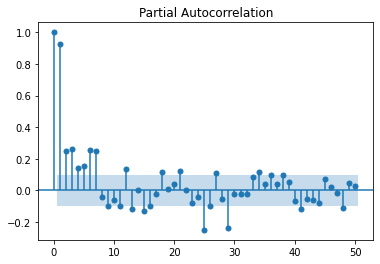

In [15]:
plot_pacf(case, lags=50)
plt.show()

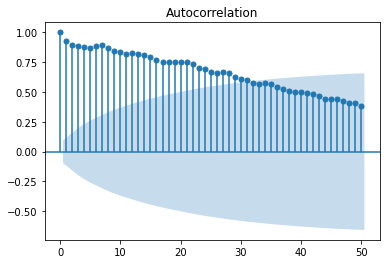

In [16]:
plot_acf(case, lags=50)
plt.show()

In [17]:
model = ARIMA(train_ARIMA, order=(1,0,1))
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [18]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  412
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2219.098
Date:                Sat, 18 Sep 2021   AIC                           4446.196
Time:                        11:34:35   BIC                           4462.280
Sample:                    03-18-2020   HQIC                          4452.558
                         - 05-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        997.2684    582.692      1.711      0.087    -144.787    2139.324
ar.L1          0.9962      0.002    400.447      0.000       0.991       1.001
ma.L1          0.3396      0.029     11.692      0.0

In [19]:
hasil = model_fit.forecast(10)
hasil= hasil.to_frame()

In [20]:
# ubah data menjadi supervised learning problem
reframed_seasonal = series_to_supervised(data_seasonal, 1, 1)
reframed_residual = series_to_supervised(data_residual, 1, 1)

In [21]:
# hapus kolom yg tidak akan diprediksi
reframed_seasonal.drop(reframed_seasonal.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
reframed_residual.drop(reframed_residual.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

In [22]:
# split data menjadi data train dan test
values_seasonal= reframed_seasonal.values
values_residual= reframed_residual.values

train_seasonal = values_seasonal[:n_total, :]
test_seasonal = values_seasonal[n_total:, :]

train_residual = values_residual[:n_total, :]
test_residual = values_residual[n_total:, :]

# split menjadi input dan output
seasonal_train_X, seasonal_train_y = train_seasonal[:, :-1], train_seasonal[:, -1]
seasonal_test_X, seasonal_test_y = test_seasonal[:, :-1], test_seasonal[:, -1]

residual_train_X, residual_train_y = train_residual[:, :-1], train_residual[:, -1]
residual_test_X, residual_test_y = test_residual[:, :-1], test_residual[:, -1]

# reshape input menjadi [samples, timesteps, features]
seasonal_train_X = seasonal_train_X.reshape((seasonal_train_X.shape[0], 1, seasonal_train_X.shape[1]))
seasonal_test_X = seasonal_test_X.reshape((seasonal_test_X.shape[0], 1, seasonal_test_X.shape[1]))

residual_train_X = residual_train_X.reshape((residual_train_X.shape[0], 1, residual_train_X.shape[1]))
residual_test_X = residual_test_X.reshape((residual_test_X.shape[0], 1, residual_test_X.shape[1]))


#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Epoch 1/1000
83/83 - 1s - loss: 65.7465 - val_loss: 53.2751
Epoch 2/1000
83/83 - 0s - loss: 60.3121 - val_loss: 47.2757
Epoch 3/1000
83/83 - 0s - loss: 54.9176 - val_loss: 41.2162
Epoch 4/1000
83/83 - 0s - loss: 49.3258 - val_loss: 36.2023
Epoch 5/1000
83/83 - 0s - loss: 46.2548 - val_loss: 35.6221
Epoch 6/1000
83/83 - 0s - loss: 45.2454 - val_loss: 35.2804
Epoch 7/1000
83/83 - 0s - loss: 44.3238 - val_loss: 34.7070
Epoch 8/1000
83/83 - 0s - loss: 43.0457 - val_loss: 34.4133
Epoch 9/1000
83/83 - 0s - loss: 41.7380 - val_loss: 34.3901
Epoch 10/1000
83/83 - 0s - loss: 40.8309 - val_loss: 34.3959
Epoch 11/1000
83/83 - 0s - loss: 39.5406 - val_loss: 33.8659
Epoch 12/1000
83/83 - 0s - loss: 38.4677 - val_loss: 33.3265
Epoch 13/1000
83/83 - 0s - loss: 37.5674 - val_loss: 33.7026
Epoch 14/1000
83/83 - 0s - loss: 36.6307 - val_loss: 33.6680
Epoch 15/1000
83/83 - 0s - loss: 35.3111 - val_loss: 32.8300
Epoch 16/1000
83/83 - 0s - loss: 34.6273 - val_loss: 33.0976
Epoch 17/1000
83/83 - 0s - loss: 

Epoch 135/1000
83/83 - 0s - loss: 23.5551 - val_loss: 38.2745
Epoch 136/1000
83/83 - 0s - loss: 23.5407 - val_loss: 38.0368
Epoch 137/1000
83/83 - 0s - loss: 23.4683 - val_loss: 37.8980
Epoch 138/1000
83/83 - 0s - loss: 23.5039 - val_loss: 37.4167
Epoch 139/1000
83/83 - 0s - loss: 23.3343 - val_loss: 37.9369
Epoch 140/1000
83/83 - 0s - loss: 23.1913 - val_loss: 38.0063
Epoch 141/1000
83/83 - 0s - loss: 23.0470 - val_loss: 38.0181
Epoch 142/1000
83/83 - 0s - loss: 22.8800 - val_loss: 37.8656
Epoch 143/1000
83/83 - 0s - loss: 22.8190 - val_loss: 38.0472
Epoch 144/1000
83/83 - 0s - loss: 22.7594 - val_loss: 37.8508
Epoch 145/1000
83/83 - 0s - loss: 22.6187 - val_loss: 37.7466
Epoch 146/1000
83/83 - 0s - loss: 22.4869 - val_loss: 37.6460
Epoch 147/1000
83/83 - 0s - loss: 22.4361 - val_loss: 37.7085
Epoch 148/1000
83/83 - 0s - loss: 22.3152 - val_loss: 37.4552
Epoch 149/1000
83/83 - 0s - loss: 22.3735 - val_loss: 37.4306
Epoch 150/1000
83/83 - 0s - loss: 22.0772 - val_loss: 37.2920
Epoch 15

Epoch 268/1000
83/83 - 0s - loss: 9.1693 - val_loss: 28.3277
Epoch 269/1000
83/83 - 0s - loss: 8.9989 - val_loss: 28.3385
Epoch 270/1000
83/83 - 0s - loss: 8.9100 - val_loss: 25.8573
Epoch 271/1000
83/83 - 0s - loss: 8.8363 - val_loss: 27.8784
Epoch 272/1000
83/83 - 0s - loss: 8.5771 - val_loss: 25.1462
Epoch 273/1000
83/83 - 0s - loss: 8.4842 - val_loss: 28.0048
Epoch 274/1000
83/83 - 0s - loss: 8.3633 - val_loss: 25.6865
Epoch 275/1000
83/83 - 0s - loss: 8.2150 - val_loss: 25.5443
Epoch 276/1000
83/83 - 0s - loss: 8.0825 - val_loss: 25.1240
Epoch 277/1000
83/83 - 0s - loss: 8.2394 - val_loss: 25.5281
Epoch 278/1000
83/83 - 0s - loss: 8.1596 - val_loss: 27.8398
Epoch 279/1000
83/83 - 0s - loss: 7.9275 - val_loss: 23.9047
Epoch 280/1000
83/83 - 0s - loss: 8.1010 - val_loss: 25.5778
Epoch 281/1000
83/83 - 0s - loss: 8.1422 - val_loss: 24.9982
Epoch 282/1000
83/83 - 0s - loss: 7.7572 - val_loss: 23.1816
Epoch 283/1000
83/83 - 0s - loss: 7.6316 - val_loss: 23.4757
Epoch 284/1000
83/83 - 0

Epoch 403/1000
83/83 - 0s - loss: 5.8573 - val_loss: 12.9838
Epoch 404/1000
83/83 - 0s - loss: 6.0979 - val_loss: 14.6910
Epoch 405/1000
83/83 - 0s - loss: 5.9084 - val_loss: 14.4591
Epoch 406/1000
83/83 - 0s - loss: 6.1153 - val_loss: 15.0395
Epoch 407/1000
83/83 - 0s - loss: 5.7581 - val_loss: 14.5122
Epoch 408/1000
83/83 - 0s - loss: 6.0618 - val_loss: 14.2899
Epoch 409/1000
83/83 - 0s - loss: 5.7251 - val_loss: 14.1101
Epoch 410/1000
83/83 - 0s - loss: 5.9280 - val_loss: 13.5764
Epoch 411/1000
83/83 - 0s - loss: 5.8416 - val_loss: 13.7854
Epoch 412/1000
83/83 - 0s - loss: 6.0513 - val_loss: 15.6943
Epoch 413/1000
83/83 - 0s - loss: 5.8336 - val_loss: 13.9454
Epoch 414/1000
83/83 - 0s - loss: 5.8565 - val_loss: 14.5054
Epoch 415/1000
83/83 - 0s - loss: 5.8727 - val_loss: 14.6708
Epoch 416/1000
83/83 - 0s - loss: 5.9513 - val_loss: 14.1622
Epoch 417/1000
83/83 - 0s - loss: 5.9100 - val_loss: 13.9875
Epoch 418/1000
83/83 - 0s - loss: 6.0759 - val_loss: 13.0372
Epoch 419/1000
83/83 - 0

Epoch 538/1000
83/83 - 0s - loss: 5.1516 - val_loss: 10.3670
Epoch 539/1000
83/83 - 0s - loss: 5.1142 - val_loss: 10.0989
Epoch 540/1000
83/83 - 0s - loss: 5.1920 - val_loss: 10.5540
Epoch 541/1000
83/83 - 0s - loss: 5.1172 - val_loss: 10.8587
Epoch 542/1000
83/83 - 0s - loss: 5.0970 - val_loss: 10.8880
Epoch 543/1000
83/83 - 0s - loss: 5.0811 - val_loss: 11.1097
Epoch 544/1000
83/83 - 0s - loss: 5.1356 - val_loss: 10.7839
Epoch 545/1000
83/83 - 0s - loss: 5.1354 - val_loss: 11.1544
Epoch 546/1000
83/83 - 0s - loss: 5.0620 - val_loss: 9.8715
Epoch 547/1000
83/83 - 0s - loss: 5.0638 - val_loss: 11.6267
Epoch 548/1000
83/83 - 0s - loss: 4.9358 - val_loss: 10.6407
Epoch 549/1000
83/83 - 0s - loss: 5.1192 - val_loss: 10.5294
Epoch 550/1000
83/83 - 0s - loss: 5.1595 - val_loss: 10.5097
Epoch 551/1000
83/83 - 0s - loss: 5.1386 - val_loss: 10.5411
Epoch 552/1000
83/83 - 0s - loss: 5.1868 - val_loss: 10.3579
Epoch 553/1000
83/83 - 0s - loss: 5.0343 - val_loss: 10.6764
Epoch 554/1000
83/83 - 0s

Epoch 673/1000
83/83 - 0s - loss: 4.4465 - val_loss: 9.7870
Epoch 674/1000
83/83 - 0s - loss: 4.2397 - val_loss: 9.6929
Epoch 675/1000
83/83 - 0s - loss: 4.3709 - val_loss: 9.6703
Epoch 676/1000
83/83 - 0s - loss: 4.3018 - val_loss: 9.9475
Epoch 677/1000
83/83 - 0s - loss: 4.4021 - val_loss: 9.9755
Epoch 678/1000
83/83 - 0s - loss: 4.2799 - val_loss: 9.6879
Epoch 679/1000
83/83 - 0s - loss: 4.1962 - val_loss: 9.9457
Epoch 680/1000
83/83 - 0s - loss: 4.2604 - val_loss: 10.6364
Epoch 681/1000
83/83 - 0s - loss: 4.4566 - val_loss: 11.3252
Epoch 682/1000
83/83 - 0s - loss: 4.2964 - val_loss: 10.3240
Epoch 683/1000
83/83 - 0s - loss: 4.2755 - val_loss: 9.3681
Epoch 684/1000
83/83 - 0s - loss: 4.4037 - val_loss: 10.3991
Epoch 685/1000
83/83 - 0s - loss: 4.2700 - val_loss: 10.1605
Epoch 686/1000
83/83 - 0s - loss: 4.1043 - val_loss: 9.3484
Epoch 687/1000
83/83 - 0s - loss: 4.0856 - val_loss: 9.0778
Epoch 688/1000
83/83 - 0s - loss: 4.3622 - val_loss: 10.1319
Epoch 689/1000
83/83 - 0s - loss: 

Epoch 809/1000
83/83 - 0s - loss: 3.5883 - val_loss: 10.5831
Epoch 810/1000
83/83 - 0s - loss: 3.7518 - val_loss: 13.1478
Epoch 811/1000
83/83 - 0s - loss: 3.6469 - val_loss: 10.2924
Epoch 812/1000
83/83 - 0s - loss: 3.6085 - val_loss: 10.6579
Epoch 813/1000
83/83 - 0s - loss: 3.6733 - val_loss: 11.4211
Epoch 814/1000
83/83 - 0s - loss: 3.4515 - val_loss: 11.3996
Epoch 815/1000
83/83 - 0s - loss: 3.8633 - val_loss: 11.3169
Epoch 816/1000
83/83 - 0s - loss: 3.6021 - val_loss: 11.1261
Epoch 817/1000
83/83 - 0s - loss: 3.6658 - val_loss: 12.1366
Epoch 818/1000
83/83 - 0s - loss: 3.7781 - val_loss: 10.4533
Epoch 819/1000
83/83 - 0s - loss: 3.4975 - val_loss: 9.7415
Epoch 820/1000
83/83 - 0s - loss: 3.4465 - val_loss: 10.0860
Epoch 821/1000
83/83 - 0s - loss: 3.5323 - val_loss: 10.1026
Epoch 822/1000
83/83 - 0s - loss: 3.6829 - val_loss: 11.5523
Epoch 823/1000
83/83 - 0s - loss: 3.4848 - val_loss: 10.3993
Epoch 824/1000
83/83 - 0s - loss: 3.4524 - val_loss: 10.6497
Epoch 825/1000
83/83 - 0s

Epoch 944/1000
83/83 - 1s - loss: 3.1149 - val_loss: 10.1134
Epoch 945/1000
83/83 - 0s - loss: 3.2047 - val_loss: 10.7936
Epoch 946/1000
83/83 - 0s - loss: 3.2093 - val_loss: 11.5568
Epoch 947/1000
83/83 - 0s - loss: 3.2128 - val_loss: 10.6792
Epoch 948/1000
83/83 - 0s - loss: 3.1887 - val_loss: 10.3443
Epoch 949/1000
83/83 - 0s - loss: 3.0288 - val_loss: 10.0008
Epoch 950/1000
83/83 - 0s - loss: 3.2188 - val_loss: 10.7984
Epoch 951/1000
83/83 - 0s - loss: 3.0954 - val_loss: 10.2695
Epoch 952/1000
83/83 - 0s - loss: 3.1783 - val_loss: 10.0447
Epoch 953/1000
83/83 - 0s - loss: 3.0553 - val_loss: 10.1611
Epoch 954/1000
83/83 - 0s - loss: 2.9370 - val_loss: 9.9762
Epoch 955/1000
83/83 - 0s - loss: 3.2125 - val_loss: 10.4893
Epoch 956/1000
83/83 - 0s - loss: 3.0628 - val_loss: 10.2773
Epoch 957/1000
83/83 - 0s - loss: 3.1722 - val_loss: 10.5784
Epoch 958/1000
83/83 - 0s - loss: 3.0992 - val_loss: 10.7855
Epoch 959/1000
83/83 - 0s - loss: 3.0242 - val_loss: 10.7630
Epoch 960/1000
83/83 - 0s

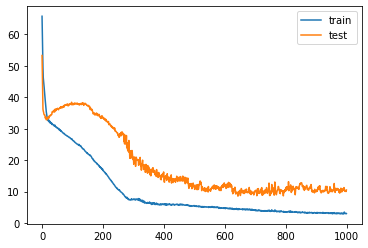

In [23]:
# LSTM model untuk seasonal
model1 = Sequential()
model1.add(LSTM(neuron_seasonal, input_shape=(seasonal_train_X.shape[1], seasonal_train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(seasonal_train_X, seasonal_train_y, epochs=epooch_seasonal, batch_size=size_batch, validation_data=(seasonal_test_X, seasonal_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat_seasonality = model1.predict(seasonal_test_X)
yhat_seasonality

array([[ -31.118551 ],
       [  -1.0435722],
       [  46.405254 ],
       [  72.53353  ],
       [  82.98012  ],
       [ -37.196606 ],
       [-173.15912  ],
       [ -30.242037 ],
       [   4.7428236],
       [  46.18069  ]], dtype=float32)

Epoch 1/1500
83/83 - 1s - loss: 151.5090 - val_loss: 66.2906
Epoch 2/1500
83/83 - 0s - loss: 151.0987 - val_loss: 66.8328
Epoch 3/1500
83/83 - 0s - loss: 150.8798 - val_loss: 67.2872
Epoch 4/1500
83/83 - 0s - loss: 150.6804 - val_loss: 67.7147
Epoch 5/1500
83/83 - 0s - loss: 150.5066 - val_loss: 68.2031
Epoch 6/1500
83/83 - 0s - loss: 150.4017 - val_loss: 68.5523
Epoch 7/1500
83/83 - 0s - loss: 150.1776 - val_loss: 68.8899
Epoch 8/1500
83/83 - 0s - loss: 150.0765 - val_loss: 69.3289
Epoch 9/1500
83/83 - 0s - loss: 149.9553 - val_loss: 69.5612
Epoch 10/1500
83/83 - 0s - loss: 149.8549 - val_loss: 69.9453
Epoch 11/1500
83/83 - 0s - loss: 149.7208 - val_loss: 70.5646
Epoch 12/1500
83/83 - 0s - loss: 149.5629 - val_loss: 70.8393
Epoch 13/1500
83/83 - 0s - loss: 149.4810 - val_loss: 71.2181
Epoch 14/1500
83/83 - 0s - loss: 149.3303 - val_loss: 71.4850
Epoch 15/1500
83/83 - 0s - loss: 149.2504 - val_loss: 71.6403
Epoch 16/1500
83/83 - 0s - loss: 149.1739 - val_loss: 71.9294
Epoch 17/1500
83/

Epoch 133/1500
83/83 - 0s - loss: 144.9277 - val_loss: 72.2853
Epoch 134/1500
83/83 - 0s - loss: 144.8070 - val_loss: 71.6136
Epoch 135/1500
83/83 - 0s - loss: 144.7538 - val_loss: 71.7546
Epoch 136/1500
83/83 - 0s - loss: 144.7019 - val_loss: 71.4683
Epoch 137/1500
83/83 - 0s - loss: 144.7497 - val_loss: 71.7845
Epoch 138/1500
83/83 - 0s - loss: 144.6613 - val_loss: 72.0947
Epoch 139/1500
83/83 - 0s - loss: 144.6172 - val_loss: 72.0828
Epoch 140/1500
83/83 - 1s - loss: 144.5930 - val_loss: 72.1422
Epoch 141/1500
83/83 - 0s - loss: 144.6022 - val_loss: 72.3708
Epoch 142/1500
83/83 - 0s - loss: 144.5844 - val_loss: 71.8941
Epoch 143/1500
83/83 - 0s - loss: 144.5077 - val_loss: 71.9785
Epoch 144/1500
83/83 - 0s - loss: 144.5328 - val_loss: 72.8556
Epoch 145/1500
83/83 - 0s - loss: 144.5376 - val_loss: 71.8801
Epoch 146/1500
83/83 - 0s - loss: 144.4556 - val_loss: 72.2385
Epoch 147/1500
83/83 - 0s - loss: 144.4639 - val_loss: 71.4630
Epoch 148/1500
83/83 - 0s - loss: 144.4568 - val_loss: 

83/83 - 0s - loss: 141.1428 - val_loss: 70.1165
Epoch 264/1500
83/83 - 0s - loss: 141.2011 - val_loss: 69.9932
Epoch 265/1500
83/83 - 0s - loss: 141.1158 - val_loss: 70.8121
Epoch 266/1500
83/83 - 0s - loss: 141.1134 - val_loss: 69.0136
Epoch 267/1500
83/83 - 0s - loss: 141.2382 - val_loss: 69.9129
Epoch 268/1500
83/83 - 0s - loss: 141.0469 - val_loss: 68.5527
Epoch 269/1500
83/83 - 0s - loss: 141.0106 - val_loss: 69.2466
Epoch 270/1500
83/83 - 0s - loss: 140.9255 - val_loss: 69.6705
Epoch 271/1500
83/83 - 0s - loss: 140.9145 - val_loss: 68.6964
Epoch 272/1500
83/83 - 0s - loss: 140.8615 - val_loss: 69.3494
Epoch 273/1500
83/83 - 0s - loss: 140.8815 - val_loss: 69.3947
Epoch 274/1500
83/83 - 1s - loss: 140.8882 - val_loss: 69.2105
Epoch 275/1500
83/83 - 0s - loss: 141.0760 - val_loss: 69.3292
Epoch 276/1500
83/83 - 0s - loss: 140.8839 - val_loss: 68.5188
Epoch 277/1500
83/83 - 0s - loss: 140.8395 - val_loss: 69.0478
Epoch 278/1500
83/83 - 0s - loss: 140.8209 - val_loss: 68.7807
Epoch 2

Epoch 394/1500
83/83 - 0s - loss: 137.1879 - val_loss: 66.1817
Epoch 395/1500
83/83 - 0s - loss: 137.0947 - val_loss: 65.6929
Epoch 396/1500
83/83 - 0s - loss: 137.2546 - val_loss: 67.2993
Epoch 397/1500
83/83 - 0s - loss: 137.2989 - val_loss: 66.0908
Epoch 398/1500
83/83 - 0s - loss: 137.1338 - val_loss: 66.7335
Epoch 399/1500
83/83 - 0s - loss: 137.1272 - val_loss: 65.8965
Epoch 400/1500
83/83 - 0s - loss: 137.1620 - val_loss: 65.8385
Epoch 401/1500
83/83 - 0s - loss: 137.1292 - val_loss: 65.6210
Epoch 402/1500
83/83 - 0s - loss: 137.1027 - val_loss: 64.9276
Epoch 403/1500
83/83 - 0s - loss: 137.2332 - val_loss: 65.9764
Epoch 404/1500
83/83 - 0s - loss: 137.0514 - val_loss: 65.8245
Epoch 405/1500
83/83 - 0s - loss: 136.9035 - val_loss: 65.5868
Epoch 406/1500
83/83 - 0s - loss: 136.9880 - val_loss: 67.0282
Epoch 407/1500
83/83 - 0s - loss: 137.0367 - val_loss: 65.5422
Epoch 408/1500
83/83 - 0s - loss: 136.8909 - val_loss: 66.5762
Epoch 409/1500
83/83 - 1s - loss: 136.8649 - val_loss: 

83/83 - 0s - loss: 133.1945 - val_loss: 65.1710
Epoch 525/1500
83/83 - 0s - loss: 132.9812 - val_loss: 63.2694
Epoch 526/1500
83/83 - 0s - loss: 133.0614 - val_loss: 63.4562
Epoch 527/1500
83/83 - 0s - loss: 133.0763 - val_loss: 64.0066
Epoch 528/1500
83/83 - 0s - loss: 133.0784 - val_loss: 63.2912
Epoch 529/1500
83/83 - 0s - loss: 132.9507 - val_loss: 64.8294
Epoch 530/1500
83/83 - 0s - loss: 133.0623 - val_loss: 63.1330
Epoch 531/1500
83/83 - 0s - loss: 132.8348 - val_loss: 63.3305
Epoch 532/1500
83/83 - 0s - loss: 132.9790 - val_loss: 63.0506
Epoch 533/1500
83/83 - 0s - loss: 132.8505 - val_loss: 64.1387
Epoch 534/1500
83/83 - 0s - loss: 132.8013 - val_loss: 63.5121
Epoch 535/1500
83/83 - 0s - loss: 132.7014 - val_loss: 63.2372
Epoch 536/1500
83/83 - 0s - loss: 132.7537 - val_loss: 63.0133
Epoch 537/1500
83/83 - 0s - loss: 132.6154 - val_loss: 62.9631
Epoch 538/1500
83/83 - 0s - loss: 132.6168 - val_loss: 62.0553
Epoch 539/1500
83/83 - 0s - loss: 132.7732 - val_loss: 64.0168
Epoch 5

Epoch 655/1500
83/83 - 0s - loss: 129.3714 - val_loss: 63.1864
Epoch 656/1500
83/83 - 0s - loss: 129.2015 - val_loss: 62.5419
Epoch 657/1500
83/83 - 0s - loss: 129.0854 - val_loss: 64.3368
Epoch 658/1500
83/83 - 0s - loss: 129.1667 - val_loss: 63.5286
Epoch 659/1500
83/83 - 0s - loss: 129.1004 - val_loss: 63.7840
Epoch 660/1500
83/83 - 0s - loss: 129.1138 - val_loss: 62.9944
Epoch 661/1500
83/83 - 0s - loss: 129.3281 - val_loss: 63.5295
Epoch 662/1500
83/83 - 0s - loss: 129.0410 - val_loss: 62.6402
Epoch 663/1500
83/83 - 0s - loss: 128.8613 - val_loss: 63.3915
Epoch 664/1500
83/83 - 0s - loss: 129.1162 - val_loss: 62.9127
Epoch 665/1500
83/83 - 0s - loss: 128.9769 - val_loss: 63.5454
Epoch 666/1500
83/83 - 0s - loss: 128.9035 - val_loss: 62.9062
Epoch 667/1500
83/83 - 0s - loss: 128.9443 - val_loss: 63.2092
Epoch 668/1500
83/83 - 0s - loss: 128.9405 - val_loss: 62.6557
Epoch 669/1500
83/83 - 0s - loss: 129.0303 - val_loss: 61.9061
Epoch 670/1500
83/83 - 0s - loss: 128.8554 - val_loss: 

83/83 - 0s - loss: 125.8706 - val_loss: 64.3639
Epoch 786/1500
83/83 - 0s - loss: 125.2225 - val_loss: 61.4313
Epoch 787/1500
83/83 - 0s - loss: 125.0708 - val_loss: 62.7605
Epoch 788/1500
83/83 - 0s - loss: 125.0805 - val_loss: 61.3078
Epoch 789/1500
83/83 - 0s - loss: 125.3048 - val_loss: 62.9173
Epoch 790/1500
83/83 - 0s - loss: 125.3327 - val_loss: 62.0792
Epoch 791/1500
83/83 - 0s - loss: 125.2999 - val_loss: 61.4882
Epoch 792/1500
83/83 - 0s - loss: 125.0886 - val_loss: 62.2309
Epoch 793/1500
83/83 - 0s - loss: 124.9362 - val_loss: 62.6198
Epoch 794/1500
83/83 - 0s - loss: 124.9962 - val_loss: 62.2900
Epoch 795/1500
83/83 - 0s - loss: 124.9703 - val_loss: 63.6795
Epoch 796/1500
83/83 - 0s - loss: 124.9977 - val_loss: 62.6226
Epoch 797/1500
83/83 - 0s - loss: 125.1362 - val_loss: 65.8546
Epoch 798/1500
83/83 - 0s - loss: 124.7180 - val_loss: 65.2033
Epoch 799/1500
83/83 - 0s - loss: 124.9062 - val_loss: 63.9294
Epoch 800/1500
83/83 - 0s - loss: 124.7697 - val_loss: 65.5320
Epoch 8

Epoch 916/1500
83/83 - 1s - loss: 121.8233 - val_loss: 67.7006
Epoch 917/1500
83/83 - 1s - loss: 122.3047 - val_loss: 67.9736
Epoch 918/1500
83/83 - 1s - loss: 121.9850 - val_loss: 65.2514
Epoch 919/1500
83/83 - 1s - loss: 121.6606 - val_loss: 65.1109
Epoch 920/1500
83/83 - 1s - loss: 121.9913 - val_loss: 64.3029
Epoch 921/1500
83/83 - 1s - loss: 122.0695 - val_loss: 66.7270
Epoch 922/1500
83/83 - 1s - loss: 121.8494 - val_loss: 63.6933
Epoch 923/1500
83/83 - 1s - loss: 121.5424 - val_loss: 66.3370
Epoch 924/1500
83/83 - 1s - loss: 121.7880 - val_loss: 65.8401
Epoch 925/1500
83/83 - 1s - loss: 121.6243 - val_loss: 66.1656
Epoch 926/1500
83/83 - 1s - loss: 122.0457 - val_loss: 65.5900
Epoch 927/1500
83/83 - 1s - loss: 121.6881 - val_loss: 64.0039
Epoch 928/1500
83/83 - 1s - loss: 121.8339 - val_loss: 65.2995
Epoch 929/1500
83/83 - 1s - loss: 121.9635 - val_loss: 67.0235
Epoch 930/1500
83/83 - 0s - loss: 121.7246 - val_loss: 66.4171
Epoch 931/1500
83/83 - 1s - loss: 121.9616 - val_loss: 

Epoch 1046/1500
83/83 - 0s - loss: 118.7545 - val_loss: 68.7251
Epoch 1047/1500
83/83 - 0s - loss: 119.2366 - val_loss: 70.4808
Epoch 1048/1500
83/83 - 0s - loss: 119.0265 - val_loss: 68.5721
Epoch 1049/1500
83/83 - 0s - loss: 118.7528 - val_loss: 68.1528
Epoch 1050/1500
83/83 - 0s - loss: 118.6914 - val_loss: 68.4130
Epoch 1051/1500
83/83 - 0s - loss: 118.5814 - val_loss: 67.4633
Epoch 1052/1500
83/83 - 0s - loss: 118.8412 - val_loss: 67.7463
Epoch 1053/1500
83/83 - 0s - loss: 118.7023 - val_loss: 67.0671
Epoch 1054/1500
83/83 - 0s - loss: 118.4080 - val_loss: 67.2533
Epoch 1055/1500
83/83 - 0s - loss: 118.5150 - val_loss: 67.4808
Epoch 1056/1500
83/83 - 0s - loss: 118.4333 - val_loss: 68.1935
Epoch 1057/1500
83/83 - 0s - loss: 119.1731 - val_loss: 67.6004
Epoch 1058/1500
83/83 - 0s - loss: 118.9120 - val_loss: 67.6634
Epoch 1059/1500
83/83 - 0s - loss: 118.8105 - val_loss: 68.1626
Epoch 1060/1500
83/83 - 0s - loss: 118.5752 - val_loss: 66.2285
Epoch 1061/1500
83/83 - 0s - loss: 118.7

83/83 - 0s - loss: 116.4127 - val_loss: 72.0577
Epoch 1175/1500
83/83 - 1s - loss: 116.3636 - val_loss: 71.9019
Epoch 1176/1500
83/83 - 1s - loss: 116.5478 - val_loss: 73.0846
Epoch 1177/1500
83/83 - 0s - loss: 116.3683 - val_loss: 72.4591
Epoch 1178/1500
83/83 - 0s - loss: 115.8935 - val_loss: 73.0722
Epoch 1179/1500
83/83 - 0s - loss: 116.5423 - val_loss: 71.5894
Epoch 1180/1500
83/83 - 0s - loss: 116.2663 - val_loss: 71.7296
Epoch 1181/1500
83/83 - 0s - loss: 116.1318 - val_loss: 71.4962
Epoch 1182/1500
83/83 - 0s - loss: 116.1310 - val_loss: 72.0458
Epoch 1183/1500
83/83 - 0s - loss: 116.2384 - val_loss: 71.7546
Epoch 1184/1500
83/83 - 0s - loss: 115.9962 - val_loss: 72.8434
Epoch 1185/1500
83/83 - 0s - loss: 116.5531 - val_loss: 72.1278
Epoch 1186/1500
83/83 - 0s - loss: 116.2753 - val_loss: 75.0466
Epoch 1187/1500
83/83 - 0s - loss: 116.2728 - val_loss: 73.2951
Epoch 1188/1500
83/83 - 0s - loss: 115.8351 - val_loss: 72.7078
Epoch 1189/1500
83/83 - 0s - loss: 116.0500 - val_loss: 

Epoch 1303/1500
83/83 - 0s - loss: 113.8646 - val_loss: 74.7545
Epoch 1304/1500
83/83 - 0s - loss: 114.0483 - val_loss: 74.6091
Epoch 1305/1500
83/83 - 0s - loss: 114.0355 - val_loss: 74.5387
Epoch 1306/1500
83/83 - 0s - loss: 114.0334 - val_loss: 75.2955
Epoch 1307/1500
83/83 - 0s - loss: 113.6435 - val_loss: 74.0599
Epoch 1308/1500
83/83 - 0s - loss: 113.7147 - val_loss: 76.7301
Epoch 1309/1500
83/83 - 0s - loss: 113.6803 - val_loss: 75.5295
Epoch 1310/1500
83/83 - 0s - loss: 113.5576 - val_loss: 74.2990
Epoch 1311/1500
83/83 - 0s - loss: 113.5243 - val_loss: 75.8637
Epoch 1312/1500
83/83 - 0s - loss: 113.4008 - val_loss: 76.7859
Epoch 1313/1500
83/83 - 0s - loss: 113.7739 - val_loss: 74.8433
Epoch 1314/1500
83/83 - 0s - loss: 113.8906 - val_loss: 76.3768
Epoch 1315/1500
83/83 - 0s - loss: 114.0852 - val_loss: 74.9239
Epoch 1316/1500
83/83 - 0s - loss: 114.5430 - val_loss: 76.8970
Epoch 1317/1500
83/83 - 0s - loss: 113.6609 - val_loss: 72.6323
Epoch 1318/1500
83/83 - 0s - loss: 113.2

83/83 - 0s - loss: 111.6580 - val_loss: 77.7207
Epoch 1432/1500
83/83 - 0s - loss: 111.3932 - val_loss: 76.6719
Epoch 1433/1500
83/83 - 0s - loss: 111.7966 - val_loss: 76.9329
Epoch 1434/1500
83/83 - 0s - loss: 111.8186 - val_loss: 76.2814
Epoch 1435/1500
83/83 - 0s - loss: 112.2236 - val_loss: 75.1887
Epoch 1436/1500
83/83 - 0s - loss: 111.8165 - val_loss: 75.1431
Epoch 1437/1500
83/83 - 0s - loss: 111.6375 - val_loss: 73.9872
Epoch 1438/1500
83/83 - 0s - loss: 111.4792 - val_loss: 76.1048
Epoch 1439/1500
83/83 - 0s - loss: 111.5418 - val_loss: 77.1704
Epoch 1440/1500
83/83 - 0s - loss: 111.6267 - val_loss: 74.9531
Epoch 1441/1500
83/83 - 0s - loss: 111.5770 - val_loss: 75.4460
Epoch 1442/1500
83/83 - 0s - loss: 111.4582 - val_loss: 73.8483
Epoch 1443/1500
83/83 - 0s - loss: 111.8678 - val_loss: 76.3510
Epoch 1444/1500
83/83 - 0s - loss: 111.7507 - val_loss: 77.0853
Epoch 1445/1500
83/83 - 0s - loss: 112.0092 - val_loss: 73.2030
Epoch 1446/1500
83/83 - 0s - loss: 111.7503 - val_loss: 

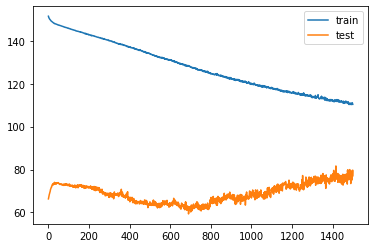

In [25]:
# LSTM model untuk residual
model2 = Sequential()
model2.add(LSTM(neuron_residual, input_shape=(residual_train_X.shape[1], residual_train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(residual_train_X, residual_train_y, epochs=epooch_residual, batch_size=size_batch, validation_data=(residual_test_X, residual_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
# make a prediction
yhat_residual = model2.predict(residual_test_X)
yhat_residual

array([[  45.7101  ],
       [  44.738247],
       [  66.62095 ],
       [ -21.263739],
       [ -41.442966],
       [-110.19672 ],
       [ -90.44739 ],
       [ -11.830859],
       [-144.2671  ],
       [ -23.492155]], dtype=float32)

In [27]:
data_evaluasi

,case
date,
2021-05-05,845
2021-05-06,905
2021-05-07,783
2021-05-08,732
2021-05-09,809
2021-05-10,694
2021-05-11,406
2021-05-12,656
2021-05-13,785


In [28]:
# jadikan list semua hasil prediksi
residual_list = ndarray.tolist(yhat_residual)
seasonal_list = ndarray.tolist(yhat_seasonality)
ARIMA_list = hasil['predicted_mean'].tolist()
list_evaluasi = data_evaluasi['case'].tolist()
length = len(list_evaluasi)
hasil_final = list()

for i in range(length):
    residual_single = residual_list[i]
    seasonal_single = seasonal_list[i]
    residual_single = residual_single[0]
    seasonal_single = seasonal_single[0]
    tambah = residual_single+seasonal_single+ARIMA_list[i]
    hasil_final.append(tambah)
    #print('hasil tambah',tambah)

hasil_final

[792.5050967798139,
 822.452700513504,
 892.6254538758516,
 831.7070296516995,
 822.8091487115563,
 634.7102219890919,
 519.3253829348589,
 741.6841496029641,
 645.0547437277894,
 808.0863760711599]

In [29]:
rmse_arima = mean_squared_error(list_evaluasi, ARIMA_list, squared=False)
rmse_arima

146.0332229312683

In [30]:
mae_arima = mean_absolute_error(list_evaluasi, ARIMA_list)
mae_arima

101.95057074695823

In [31]:
mse = mean_squared_error(list_evaluasi, hasil_final)
mse

10601.047628226612

In [32]:
rmse = mean_squared_error(list_evaluasi, hasil_final, squared=False)
rmse

102.961389016595

In [33]:
mae = mean_absolute_error(list_evaluasi, hasil_final)
mae

93.2514777837891

<AxesSubplot:>

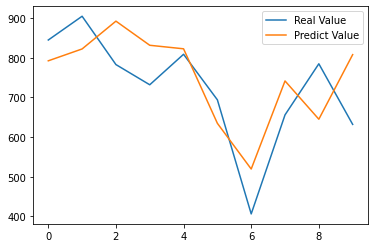

In [34]:
compare = pd.DataFrame(list(zip(list_evaluasi, hasil_final)), columns =['Real Value', 'Predict Value'])
compare.plot()